# **Earth-like Planet Detection using Hybrid Ensemble ML Architecture (Part I)**



## **Kepler Object of Interest (KOI)**

In this notebook we focus on the Kepler Project mission data source that can be found [here](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative).

We explore the open-source data collected by the Kepler transit method satellite, and build a suitable ML model for exoplanet identification.

The historical data cover the period 2009-2018. This work is built upon previous studies you can find in the [references](#references) section.

In [84]:
# Adding imports
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt


import requests
import urllib.parse
import io

import joblib

In [85]:
import warnings
# suppress all warnings
warnings.filterwarnings('ignore')

The data is queried using Astronomical Data Query Language (ADQL) is used to access the data programmatically via TAP service.

In [86]:
# define your query to select all data from cumulative table
kepler_query = "SELECT * FROM cumulative"

# use HTTP client to parse the query
encoded_query = urllib.parse.quote(kepler_query)

# use TAP url to programmatically fetch Kepler historical data
tap_url = f"https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query={encoded_query}&format=csv"

print("Downloading Kepler KOI Cumulative data...")
print(f"URL: {tap_url}")

response = requests.get(tap_url)

if response.status_code == 200:
  print("Successful download...")
else:
  print(f"Encounter error while downloading: {response.status_code}")


URL: https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=SELECT%20%2A%20FROM%20cumulative&format=csv
Successful download...


In [87]:
# Convert the downloaded data into a panda dataframe
kepler_data = pd.read_csv(io.StringIO(response.text))

print(f"Dataset shape: {kepler_data.shape}")
print(f"# of columns: {len(kepler_data.columns)}")
print(f"Sample of column names: {list(kepler_data.columns[:10])}")

Dataset shape: (9564, 153)
# of columns: 153
Sample of column names: ['kepid', 'kepoi_name', 'kepler_name', 'ra', 'ra_err', 'ra_str', 'dec', 'dec_err', 'dec_str', 'koi_gmag']


In [88]:
print(kepler_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Columns: 153 entries, kepid to koi_score
dtypes: float64(127), int64(6), object(20)
memory usage: 11.2+ MB
None


In [89]:


print("\n=== First 5 rows ===")
print(kepler_data.head())

print("\n=== Disposition counts ===")
print(kepler_data['koi_disposition'].value_counts())


=== First 5 rows ===
      kepid kepoi_name   kepler_name         ra  ra_err        ra_str  \
0  10797460  K00752.01  Kepler-227 b  291.93423     0.0  19h27m44.22s   
1  10797460  K00752.02  Kepler-227 c  291.93423     0.0  19h27m44.22s   
2  10811496  K00753.01           NaN  297.00482     0.0  19h48m01.16s   
3  10848459  K00754.01           NaN  285.53461     0.0  19h02m08.31s   
4  10854555  K00755.01  Kepler-664 b  288.75488     0.0  19h15m01.17s   

         dec  dec_err       dec_str  koi_gmag  ...  koi_fpflag_co  \
0  48.141651      0.0  +48d08m29.9s    15.890  ...              0   
1  48.141651      0.0  +48d08m29.9s    15.890  ...              0   
2  48.134129      0.0  +48d08m02.9s    15.943  ...              0   
3  48.285210      0.0  +48d17m06.8s    16.100  ...              0   
4  48.226200      0.0  +48d13m34.3s    16.015  ...              0   

   koi_fpflag_ec  koi_insol  koi_insol_err1  koi_insol_err2  koi_srho  \
0              0      93.59           29.45        

In [90]:
kepler_data.tail(5)

,kepid,kepoi_name,kepler_name,ra,ra_err,ra_str,dec,dec_err,dec_str,koi_gmag,...,koi_fpflag_co,koi_fpflag_ec,koi_insol,koi_insol_err1,koi_insol_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_score
9559,10090151,K07985.01,NaN,297.18875,0.0,19h48m45.30s,47.093819,0.0,+47d05m37.7s,14.082,...,1,0,4500.53,3406.38,-1175.26,0.16318,0.01693,-0.01718,LS+MCMC,0.000
9560,10128825,K07986.01,NaN,286.50937,0.0,19h06m02.25s,47.163219,0.0,+47d09m47.6s,15.189,...,0,0,1585.81,1537.86,-502.22,0.50770,0.07330,-0.26989,LS+MCMC,0.497
9561,10147276,K07987.01,NaN,294.16489,0.0,19h36m39.57s,47.176281,0.0,+47d10m34.6s,15.853,...,1,0,5713.41,5675.74,-1836.94,8.97692,23.11894,-8.63287,LS+MCMC,0.021
9562,10155286,K07988.01,NaN,296.76288,0.0,19h47m03.09s,47.145142,0.0,+47d08m42.5s,11.733,...,0,0,22.68,2.07,-10.95,85.88623,17.31552,-41.55038,LS+MCMC,0.092
9563,10156110,K07989.01,NaN,297.00977,0.0,19h48m02.34s,47.121021,0.0,+47d07m15.7s,15.210,...,1,1,607.42,600.39,-194.33,1.40645,0.16166,-0.95964,LS+MCMC,0.000


## **Exploratory data analysis**

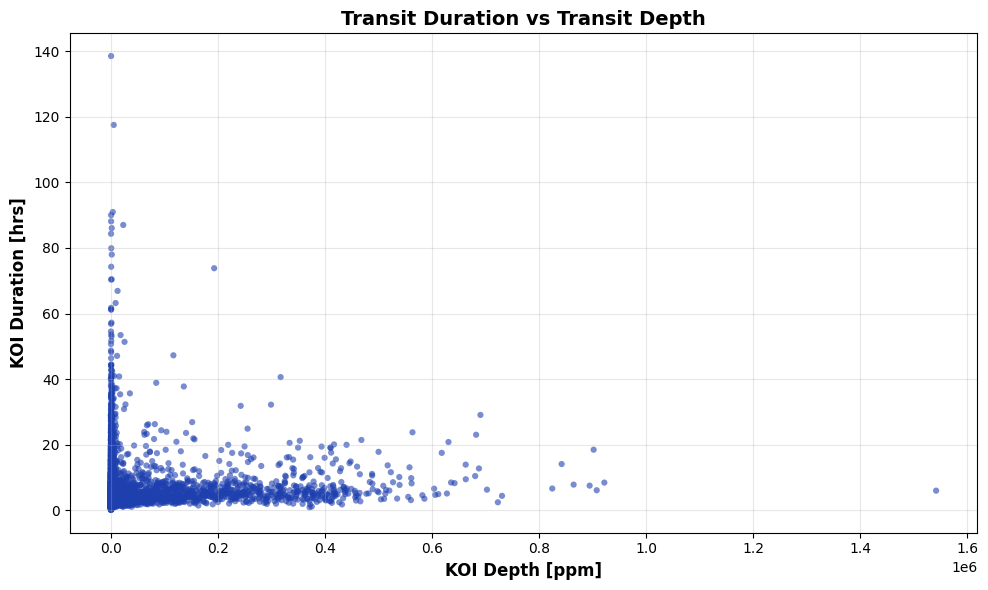

In [91]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(kepler_data['koi_depth'], kepler_data['koi_duration'],
           alpha=0.6, s=20, c='#1e40af', edgecolors='none')

# Add labels and title
plt.xlabel('KOI Depth [ppm]', fontsize=12, fontweight='bold')
plt.ylabel('KOI Duration [hrs]', fontsize=12, fontweight='bold')
plt.title('Transit Duration vs Transit Depth', fontsize=14, fontweight='bold')

# Add grid for better readability
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

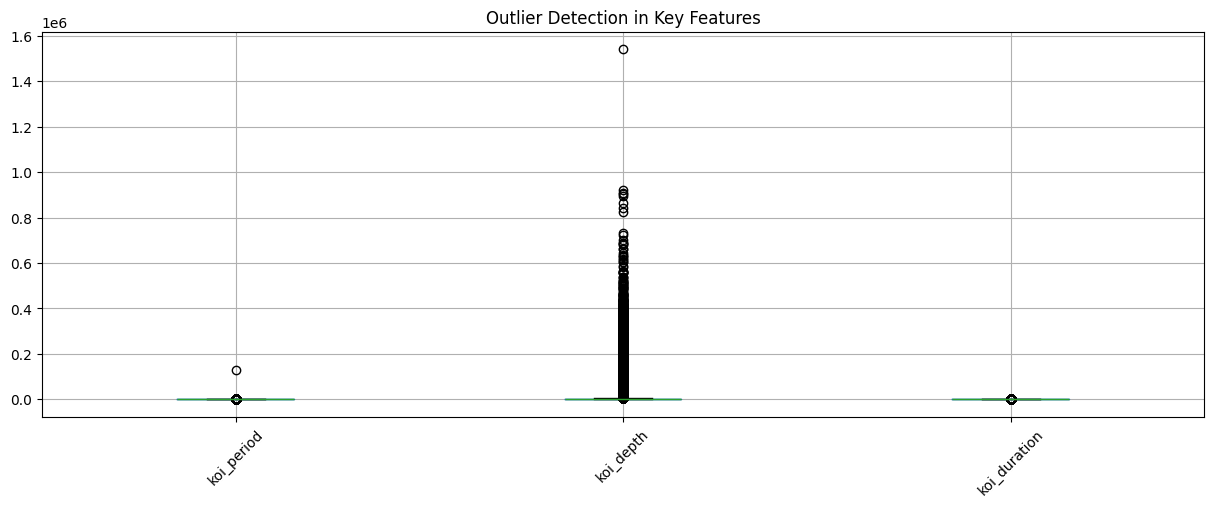

In [92]:
# where are the outliers?

# Box plots to identify outliers
plt.figure(figsize=(15, 5))
kepler_data[['koi_period', 'koi_depth', 'koi_duration']].boxplot()
plt.title('Outlier Detection in Key Features')
plt.xticks(rotation=45)
plt.show()

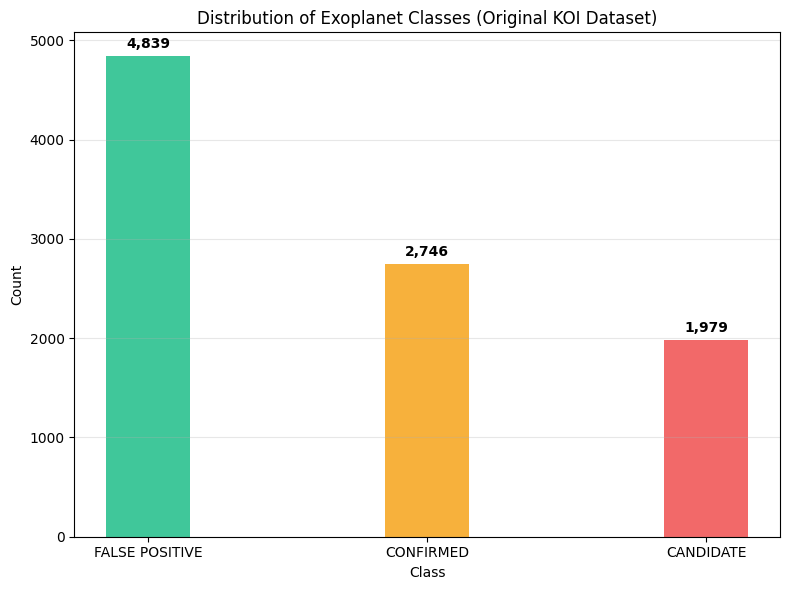

Class distribution:
FALSE POSITIVE: 4,839 (50.6%)
CONFIRMED: 2,746 (28.7%)
CANDIDATE: 1,979 (20.7%)


In [121]:
# class distribution w.t.r. to koi_disposition

plt.figure(figsize=(8, 6))
class_counts = kepler_data['koi_disposition'].value_counts()
colors = ['#10b981', '#f59e0b', '#ef4444']  # Green, Orange, Red

bars = plt.bar(class_counts.index, class_counts.values, color=colors, alpha=0.8,width=0.3)
plt.title('Distribution of Exoplanet Classes (Original KOI Dataset)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Add value labels on bars
for bar, count in zip(bars, class_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{count:,}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Class distribution:")
for class_name, count in class_counts.items():
    percentage = (count / len(kepler_data)) * 100
    print(f"{class_name}: {count:,} ({percentage:.1f}%)")




## **Data Preprocessing**

Only `koi_disposition` values corresponding to `CONFIRMED` and `CANDIDATE` are considered for classification. Initially, multi-class classification was used to include `FALSE POSITIVE` entries; however, this method yielded worse accuracy in comparison.

In [95]:
# Removing FALSE POSITIVES for binary classification
kepler_data_binary = kepler_data[kepler_data['koi_disposition'] != 'FALSE POSITIVE'].copy()
print(f"Upon removing FALSE POSITIVES: {kepler_data_binary.shape[0]} rows")
print(f"Remaining classes: {kepler_data_binary['koi_disposition'].value_counts()}")

# Create y_binary target
y_binary = kepler_data_binary['koi_disposition'].map({
    'CONFIRMED': 1,
    'CANDIDATE': 0
})

Upon removing FALSE POSITIVES: 4725 rows
Remaining classes: koi_disposition
CONFIRMED    2746
CANDIDATE    1979
Name: count, dtype: int64


In the next step, null values are inspected. Columns with `> 50%` values missing are identified.

In [96]:
missing_percentages = (kepler_data_binary.isnull().sum() / len(kepler_data_binary)) * 100

high_missing = missing_percentages[missing_percentages > 50]
print(f"Columns with >50% missing data: {len(high_missing)}")
print(high_missing.sort_values(ascending=False))

# Show columns with >80% missing
excessive_missing = missing_percentages[missing_percentages > 80]
print(f"\nColumns with >80% missing data: {len(excessive_missing)}")
print(excessive_missing.sort_values(ascending=False))

Columns with >50% missing data: 24
koi_gmag_err        100.0
koi_rmag_err        100.0
koi_imag_err        100.0
koi_zmag_err        100.0
koi_kepmag_err      100.0
koi_model_dof       100.0
koi_model_chisq     100.0
koi_eccen_err1      100.0
koi_eccen_err2      100.0
koi_longp           100.0
koi_longp_err1      100.0
koi_longp_err2      100.0
koi_sma_err1        100.0
koi_sma_err2        100.0
koi_ingress         100.0
koi_ingress_err1    100.0
koi_ingress_err2    100.0
koi_incl_err1       100.0
koi_incl_err2       100.0
koi_teq_err1        100.0
koi_teq_err2        100.0
koi_sage            100.0
koi_sage_err1       100.0
koi_sage_err2       100.0
dtype: float64

Columns with >80% missing data: 24
koi_gmag_err        100.0
koi_rmag_err        100.0
koi_imag_err        100.0
koi_zmag_err        100.0
koi_kepmag_err      100.0
koi_model_dof       100.0
koi_model_chisq     100.0
koi_eccen_err1      100.0
koi_eccen_err2      100.0
koi_longp           100.0
koi_longp_err1      100.0
koi_

In [97]:
# drop column above due to null values

columns_drop = missing_percentages[missing_percentages > 50].index.tolist()

print(f"Columns to drop: {len(columns_drop)}")
print("Dropping these columns:")
for col in columns_drop:
    print(f"  - {col} ({missing_percentages[col]:.1f}% missing)")

# Apply the drops
kepler_data_clean = kepler_data_binary.drop(columns=columns_drop)

print(f"\nInitial dataset: {kepler_data_clean.shape}")
print(f"Cleaned dataset: {kepler_data_clean.shape}")
print(f"Removed {kepler_data.shape[1] - kepler_data_clean.shape[1]} columns")

Columns to drop: 24
Dropping these columns:
  - koi_gmag_err (100.0% missing)
  - koi_rmag_err (100.0% missing)
  - koi_imag_err (100.0% missing)
  - koi_zmag_err (100.0% missing)
  - koi_kepmag_err (100.0% missing)
  - koi_model_dof (100.0% missing)
  - koi_model_chisq (100.0% missing)
  - koi_eccen_err1 (100.0% missing)
  - koi_eccen_err2 (100.0% missing)
  - koi_longp (100.0% missing)
  - koi_longp_err1 (100.0% missing)
  - koi_longp_err2 (100.0% missing)
  - koi_sma_err1 (100.0% missing)
  - koi_sma_err2 (100.0% missing)
  - koi_ingress (100.0% missing)
  - koi_ingress_err1 (100.0% missing)
  - koi_ingress_err2 (100.0% missing)
  - koi_incl_err1 (100.0% missing)
  - koi_incl_err2 (100.0% missing)
  - koi_teq_err1 (100.0% missing)
  - koi_teq_err2 (100.0% missing)
  - koi_sage (100.0% missing)
  - koi_sage_err1 (100.0% missing)
  - koi_sage_err2 (100.0% missing)

Initial dataset: (4725, 129)
Cleaned dataset: (4725, 129)
Removed 24 columns


### **Feature Engineering & Selection**

Of the initial 153 columns, 25 columns were removed. To reduce dimensionality further, Pearson correlation is used.


In [98]:
# plot correlation for numeric columns
numeric_columns = kepler_data_clean.select_dtypes(include=[np.number]).columns
correlation_matrix = kepler_data_clean[numeric_columns].corr()

print(f"Correlation matrix shape: {correlation_matrix.shape}")

Correlation matrix shape: (109, 109)


In [99]:
# Find pairs with high correlation (>0.8 or <-0.8)
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.8:  # High correlation threshold set to 0.8
            high_corr_pairs.append({
                'feature1': correlation_matrix.columns[i],
                'feature2': correlation_matrix.columns[j],
                'correlation': corr_value
            })


high_corr_df = pd.DataFrame(high_corr_pairs)
print(f"Found {len(high_corr_pairs)} highly correlated pairs:")
print(high_corr_df.sort_values('correlation', key=abs, ascending=False))

Found 91 highly correlated pairs:
            feature1         feature2  correlation
37  koi_time0bk_err1   koi_time0_err1     1.000000
87    koi_time0_err1   koi_time0_err2    -1.000000
66      koi_dor_err1     koi_dor_err2    -1.000000
62   koi_period_err1  koi_period_err2    -1.000000
58    koi_depth_err1   koi_depth_err2    -1.000000
..               ...              ...          ...
45     koi_prad_err1          koi_ror     0.821799
52        koi_impact     koi_ror_err2    -0.819624
63           koi_ror     koi_ror_err2    -0.819558
44     koi_prad_err1       koi_impact     0.814026
50        koi_impact  koi_impact_err2    -0.806706

[91 rows x 3 columns]


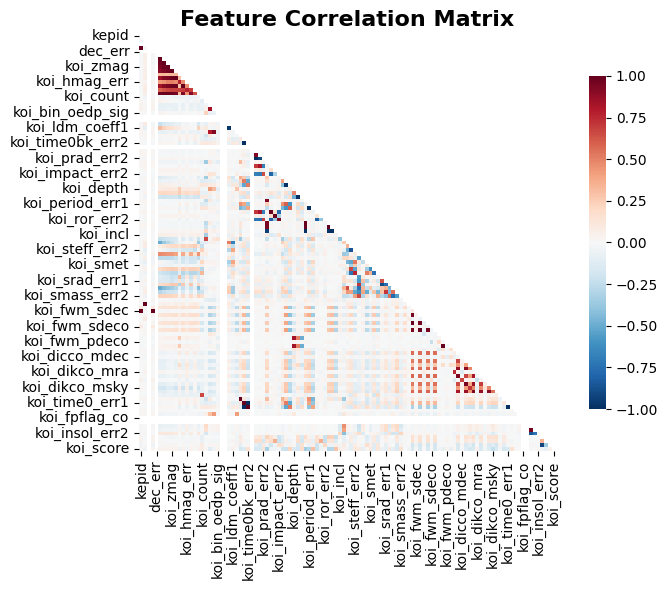

In [100]:
# Create correlation heatmap
plt.figure(figsize=(8, 6))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle

sns.heatmap(correlation_matrix,
            mask=mask,
            annot=False,
            cmap='RdBu_r',
            center=0,
            square=True,
            cbar_kws={'shrink': 0.8})

plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Given the previous graph dimensionality canbe reduced by firstly removikng highly correlated features, secondly by using the target variable `koi_disposition` and exatracting the top 20 or 30 features the variable is correlated with, while dropping everything else.

This will allow us to keep only the information necessary.

In [101]:
# Remove highly correlated features
def remove_highly_correlated_features(df, threshold=0.8):
    # Compute correlation matrix
    corr_matrix = df.select_dtypes(include=[np.number]).corr()

    # array containing highly correlated pairs
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

    features_to_remove = set()
    for feat1, feat2 in high_corr_pairs:

        if df[feat1].isnull().sum() <= df[feat2].isnull().sum():
            features_to_remove.add(feat2)
        else:
            features_to_remove.add(feat1)

    return df.drop(columns=list(features_to_remove)), list(features_to_remove)

kepler_data_final, removed_features = remove_highly_correlated_features(kepler_data_clean, threshold=0.8)

print(f"Initial features: {kepler_data_clean.shape[1]}")
print(f"After removal correlated features: {kepler_data_final.shape[1]}")
print(f"Removed {len(removed_features)} features:")
for feat in removed_features:
    print(f"  - {feat}")

Initial features: 129
After removal correlated features: 85
Removed 44 features:
  - koi_fwm_pdeco_err
  - koi_srho_err2
  - koi_time0_err2
  - koi_dor_err1
  - koi_imag
  - koi_steff_err2
  - koi_fwm_sdec
  - koi_gmag
  - koi_impact
  - koi_time0
  - dec
  - koi_dicco_mdec_err
  - koi_prad_err2
  - koi_insol_err1
  - koi_impact_err2
  - koi_max_mult_ev
  - koi_fwm_srao_err
  - koi_ror_err2
  - koi_period_err2
  - koi_dicco_msky_err
  - koi_dor_err2
  - koi_dikco_msky_err
  - koi_dicco_mra_err
  - koi_insol_err2
  - koi_hmag
  - koi_fwm_prao_err
  - koi_prad_err1
  - koi_depth_err2
  - koi_srad_err2
  - koi_time0_err1
  - koi_impact_err1
  - koi_zmag
  - koi_ldm_coeff1
  - koi_fwm_sdec_err
  - koi_kepmag
  - koi_kmag
  - koi_duration_err2
  - koi_fwm_sra
  - koi_ror
  - koi_dor
  - koi_rmag
  - koi_fwm_sdeco_err
  - koi_sma
  - koi_time0bk_err2


In the following step `koi_disposition` target is now used to further reduce the dataframe dimensionality.

In [102]:
target = 'koi_disposition'

if target in kepler_data_clean.columns:
    # Calculate correlation with 'koi_disposition'
    target_corr = kepler_data_clean.select_dtypes(include=[np.number]).corrwith(
        pd.get_dummies(kepler_data_clean[target]).iloc[:, 0]
    ).abs().sort_values(ascending=False)

    print("Top features correlated with target 'koi_disposition':")
    print(target_corr.head(10))

Top features correlated with target 'koi_disposition':
koi_fwm_sdeco_err     0.547956
koi_fwm_sdec_err      0.547860
koi_fwm_srao_err      0.547552
koi_fwm_sra_err       0.541306
koi_dicco_msky_err    0.447153
koi_dikco_msky_err    0.437682
koi_dicco_mra_err     0.425693
koi_dikco_mra_err     0.421518
koi_dicco_mdec_err    0.412034
koi_dikco_mdec_err    0.407862
dtype: float64


In [103]:
# Compute correlation with target (koi_disposition)
target_corr = kepler_data_final.select_dtypes(include=[np.number]).corrwith(
    pd.get_dummies(kepler_data_final['koi_disposition']).iloc[:, 0]
).abs().sort_values(ascending=False)

# Select top features without the target
top_20_features = target_corr.head(20).index.tolist()

top_30_features = target_corr.head(30).index.tolist()

X_20_features = kepler_data_final[top_20_features]
X_30_features = kepler_data_final[top_30_features]

# Use the y_binary you already created earlier
print(f"X_20 features shape: {X_20_features.shape}")
print(f"X_30 features shape: {X_30_features.shape}")
print(f"y_binary shape: {y_binary.shape}")
print(f"Target: koi_disposition")

X_20 features shape: (4725, 20)
X_30 features shape: (4725, 30)
y_binary shape: (4725,)
Target: koi_disposition


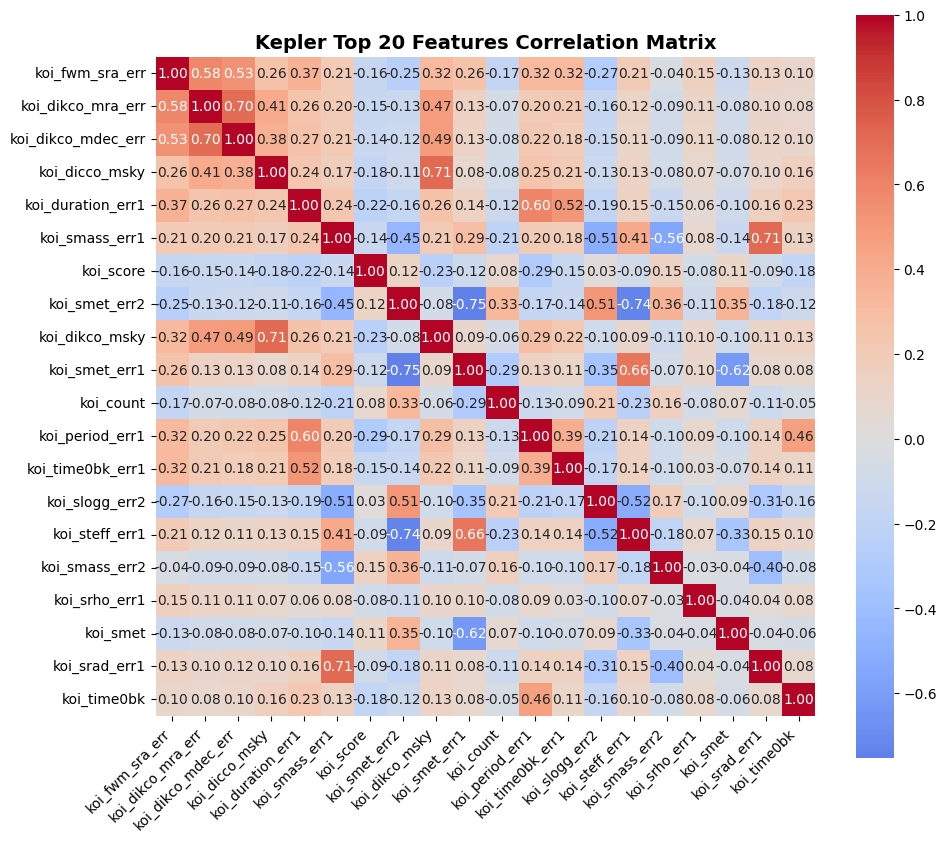

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have your top 20 features
 # Your actual feature names

# Calculate correlation matrix for top 20 features
correlation_matrix = kepler_data_clean[top_20_features].corr()

# Create the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={'shrink': 0.8})
# Rotate the labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.title('Kepler Top 20 Features Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('kepler_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [47]:
# Differences with 30-feature model
additional_features = set(top_30_features) - set(top_20_features)
print(f"\nAdditional features in 30-feature model:")
for i, feature in enumerate(additional_features, 1):
    importance = target_corr[feature]
    print(f"  {i:2d}. {feature:25s} {importance:.3f}")


Additional features in 30-feature model:
   1. koi_depth_err1            0.151
   2. koi_ldm_coeff2            0.100
   3. koi_duration              0.133
   4. koi_steff                 0.136
   5. koi_slogg                 0.162
   6. koi_smass                 0.159
   7. koi_slogg_err1            0.129
   8. koi_model_snr             0.112
   9. koi_srho                  0.161
  10. koi_jmag_err              0.088


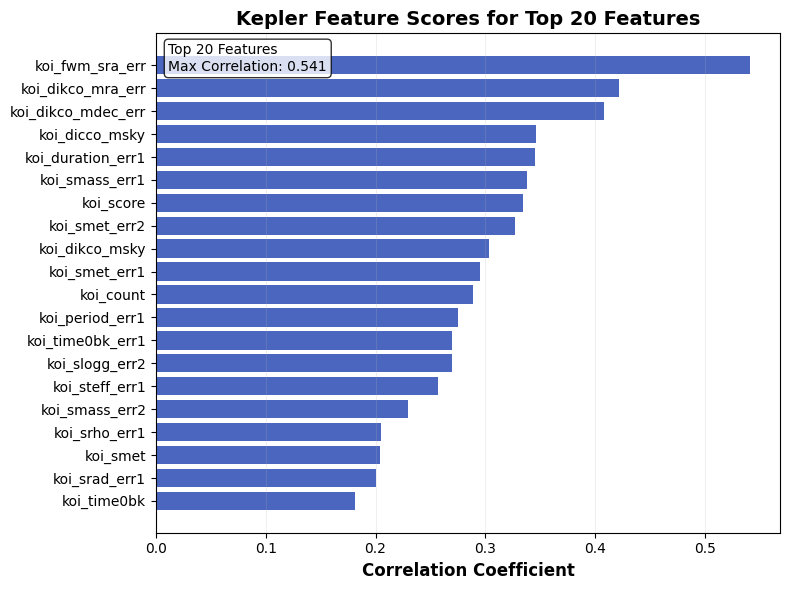

In [55]:
# Let us plot a graph to understand
fig, ax = plt.subplots(figsize=(8, 6))
top_20_features_corr = target_corr.head(20)

# Create bars
bars = ax.barh(range(len(top_20_features_corr)), top_20_features_corr.values,
               color='#1e40af', alpha=0.8, height=0.8)

# Styling
ax.set_yticks(range(len(top_20_features_corr)))
ax.set_yticklabels(top_20_features_corr.index, fontsize=10)
ax.set_xlabel('Correlation Coefficient', fontsize=12, fontweight='bold')
ax.set_title('Kepler Feature Scores for Top 20 Features', fontsize=14, fontweight='bold')

# create a grid
ax.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)

# add statistics
n_features = len(top_20_features_corr)
max_corr = top_20_features_corr.max()
ax.text(0.02, 0.98, f'Top {n_features} Features\nMax Correlation: {max_corr:.3f}',
        transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.invert_yaxis()
plt.tight_layout()
plt.show()

### **Apply Scikit-Learn Iterative Imputer**

Dispite the dimensionality is reduce there exists still null entries in the dataset. Dropping the column containing null values can cause loss of information effecting the accuracy of the model. To address this problem scikit-learn iterative imputater is used as per [[1]](#references)

The iterative imputer computes `p(x|y)` with x being the feature with missing values and y the features containing velues.

In [48]:
# check if X_features datasets are pd
print(type(X_20_features))
print(type(X_30_features))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [50]:
# Use RandomForestImputer

# Apply imputation to feature datasets only
imputer_20 = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=10, random_state=42),
    max_iter=10,
    random_state=42,
    verbose=1
)

imputer_30 = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=10, random_state=42),
    max_iter=10,
    random_state=42,
    verbose=1
)


In [51]:
# Impute missing values
X_20_imputed = imputer_20.fit_transform(X_20_features)
X_30_imputed = imputer_30.fit_transform(X_30_features)

# Convert to DataFrames
X_20_imputed_df = pd.DataFrame(X_20_imputed, columns=X_20_features.columns, index=X_20_features.index)
X_30_imputed_df = pd.DataFrame(X_30_imputed, columns=X_30_features.columns, index=X_30_features.index)

print(f"20-feature DataFrame after imputation: {X_20_imputed_df.shape}")
print(f"30-feature DataFrame after imputation: {X_30_imputed_df.shape}")

[IterativeImputer] Completing matrix with shape (4725, 20)
[IterativeImputer] Change: 100.74282401559108, scaled tolerance: 0.90704471 
[IterativeImputer] Change: 111.30440420000002, scaled tolerance: 0.90704471 
[IterativeImputer] Change: 81.99496367999998, scaled tolerance: 0.90704471 
[IterativeImputer] Change: 132.14853723999997, scaled tolerance: 0.90704471 
[IterativeImputer] Change: 108.8969121, scaled tolerance: 0.90704471 
[IterativeImputer] Change: 149.60129577, scaled tolerance: 0.90704471 
[IterativeImputer] Change: 191.11078299999997, scaled tolerance: 0.90704471 
[IterativeImputer] Change: 289.4939520000001, scaled tolerance: 0.90704471 
[IterativeImputer] Change: 307.45984660000005, scaled tolerance: 0.90704471 
[IterativeImputer] Change: 193.61510960000004, scaled tolerance: 0.90704471 
[IterativeImputer] Completing matrix with shape (4725, 30)


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[IterativeImputer] Change: 440.46695557890655, scaled tolerance: 10.894 
[IterativeImputer] Change: 348.9466892399001, scaled tolerance: 10.894 
[IterativeImputer] Change: 540.7758820600006, scaled tolerance: 10.894 
[IterativeImputer] Change: 427.88395509999975, scaled tolerance: 10.894 
[IterativeImputer] Change: 299.6462616999996, scaled tolerance: 10.894 
[IterativeImputer] Change: 432.3645534999995, scaled tolerance: 10.894 
[IterativeImputer] Change: 270.78313480000014, scaled tolerance: 10.894 
[IterativeImputer] Change: 463.99424001000045, scaled tolerance: 10.894 
[IterativeImputer] Change: 656.6959960500004, scaled tolerance: 10.894 
[IterativeImputer] Change: 382.7486146350007, scaled tolerance: 10.894 
20-feature DataFrame after imputation: (4725, 20)
30-feature DataFrame after imputation: (4725, 30)


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


## **Model Training**

For the model training, the dataset is split into training and testing dataset. The ratio is 80/20. Subsequently `StandardScaler` is applied to the split data to avoid any data leakege of the test dataset into the model.

In [56]:
# Split data using the y_binary by 80/20 split
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(
    X_20_imputed_df, y_binary, test_size=0.2, random_state=42
)

X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(
    X_30_imputed_df, y_binary, test_size=0.2, random_state=42
)

print(f"20-feature training set: {X_train_20.shape}")
print(f"20-feature test set: {X_test_20.shape}")
print(f"30-feature training set: {X_train_30.shape}")
print(f"30-feature test set: {X_test_30.shape}")

20-feature training set: (3780, 20)
20-feature test set: (945, 20)
30-feature training set: (3780, 30)
30-feature test set: (945, 30)


In [58]:
# Define a standard scaler
scaler_20 = StandardScaler()
scaler_30 = StandardScaler()

# Fit scalers on training data only
X_train_20_scaled = scaler_20.fit_transform(X_train_20)
X_test_20_scaled = scaler_20.transform(X_test_20)

X_train_30_scaled = scaler_30.fit_transform(X_train_30)
X_test_30_scaled = scaler_30.transform(X_test_30)

# Convert back to DataFrames
X_train_20_scaled_df = pd.DataFrame(X_train_20_scaled, columns=X_train_20.columns, index=X_train_20.index)
X_test_20_scaled_df = pd.DataFrame(X_test_20_scaled, columns=X_test_20.columns, index=X_test_20.index)

X_train_30_scaled_df = pd.DataFrame(X_train_30_scaled, columns=X_train_30.columns, index=X_train_30.index)
X_test_30_scaled_df = pd.DataFrame(X_test_30_scaled, columns=X_test_30.columns, index=X_test_30.index)


In [59]:
print(f"20-feature training set (scaled): {X_train_20_scaled_df.shape}")
print(f"20-feature test set (scaled): {X_test_20_scaled_df.shape}")

20-feature training set (scaled): (3780, 20)
20-feature test set (scaled): (945, 20)


Now the ensemble for the datafrane are created. Note that the maximum iteration is setto 500, after experimenting it was noted using 1000 provides negligible improvement to the model accurancy whilest increasing the training time.

In [60]:
ensemble_20 = VotingClassifier([
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(random_state=42)),
    ('svm', SVC(probability=True, random_state=42)),
    ('lr', LogisticRegression(random_state=42, max_iter=2000)),
    ('deep_nn', MLPClassifier(hidden_layer_sizes=(200, 100, 50, 25, 10), max_iter=500, random_state=42))
], voting='soft')


ensemble_30 = VotingClassifier([
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(random_state=42)),
    ('svm', SVC(probability=True, random_state=42)),
    ('lr', LogisticRegression(random_state=42, max_iter=2000)),
    ('deep_nn', MLPClassifier(hidden_layer_sizes=(200, 100, 50, 25, 10), max_iter=500, random_state=42))
], voting='soft')


### **Train 20-feature model**








In [63]:
# Train ensemble
ensemble_20.fit(X_train_20_scaled_df, y_train_20)

# Evaluation
y_pred_20 = ensemble_20.predict(X_test_20_scaled_df)

In [69]:

print(f"Ensemble_20 Accuracy: {accuracy_score(y_test_20, y_pred_20):.3f}")
print(classification_report(y_test_20, y_pred_20))

Ensemble_20 Accuracy: 0.869
              precision    recall  f1-score   support

           0       0.87      0.80      0.84       394
           1       0.87      0.92      0.89       551

    accuracy                           0.87       945
   macro avg       0.87      0.86      0.86       945
weighted avg       0.87      0.87      0.87       945



In [75]:

# Compare with 20-feature model
y_pred_proba_20 = ensemble_20.predict_proba(X_test_20_scaled)
auc_20 = roc_auc_score(y_test_20, y_pred_proba_20[:, 1])
print(f"20-Feature Model AUC Score: {auc_20:.3f}")

20-Feature Model AUC Score: 0.952


In [78]:
# Saving 20-feature model
model_package_20 = {
    'model': ensemble_20,
    'imputer': imputer_20,
    'scaler': scaler_20,
    'features': top_20_features,
    'accuracy': 0.869,
    'auc_score': 0.952,
    'mission': 'kepler',
    'classes': ['CANDIDATE', 'CONFIRMED'],
    'class_mapping': {'CANDIDATE': 0, 'CONFIRMED': 1},
    'n_features': 20,
    'performance': {
        'candidate_precision': 0.87,
        'candidate_recall': 0.80,
        'confirmed_precision': 0.87,
        'confirmed_recall': 0.92
    }
}

In [79]:
joblib.dump(model_package_20, 'kepler_20_features_model.pkl')

['kepler_20_features_model.pkl']


### **Train 30-feature model**

In [67]:
# Train ensemble
ensemble_30.fit(X_train_30_scaled_df, y_train_30)

# Evaluation
y_pred_30 = ensemble_30.predict(X_test_30_scaled_df)

In [68]:
print(f"Ensemble_30 Accuracy: {accuracy_score(y_test_30, y_pred_30):.3f}")
print(classification_report(y_test_30, y_pred_30))

Ensemble_30 Accuracy: 0.884
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       394
           1       0.88      0.93      0.90       551

    accuracy                           0.88       945
   macro avg       0.89      0.87      0.88       945
weighted avg       0.88      0.88      0.88       945



In [76]:
# Get prediction probabilities
y_pred_proba_30 = ensemble_30.predict_proba(X_test_30_scaled)

# Calculate AUC score
auc_30 = roc_auc_score(y_test_30, y_pred_proba_30[:, 1])
print(f"30-Feature Model AUC Score: {auc_30:.3f}")

30-Feature Model AUC Score: 0.956


Note that using 30 features improve the ensamble accuracy across all metrics. Now both models are saved using `.pkl`

In [77]:
# Save the 30-feature model
model_package_30 = {
    'model': ensemble_30,
    'imputer': imputer_30,
    'scaler': scaler_30,
    'features': top_30_features,
    'accuracy': 0.884,
    'auc_score': 0.956,  # Your earlier result
    'mission': 'kepler',
    'classes': ['CANDIDATE', 'CONFIRMED'],
    'class_mapping': {'CANDIDATE': 0, 'CONFIRMED': 1},
    'n_features': 30,
    'performance': {
        'candidate_precision': 0.89,
        'candidate_recall': 0.82,
        'confirmed_precision': 0.88,
        'confirmed_recall': 0.93
    }
}

joblib.dump(model_package_30, 'kepler_final_30_features.pkl')
print("Final Kepler model saved with 30 features")

Final Kepler model saved with 30 features


## **Results & Discussion**

The Hybrid ML Ensemble Architecture provides improved performance for the 30 top features comapred to Top-20 features model.

```
model_package_30 = {
    'model': ensemble_30,
    'imputer': imputer_30,
    'scaler': scaler_30,
    'features': top_30_features,
    'accuracy': 0.884,
    'auc_score': 0.956,  
    'mission': 'kepler',
    'classes': ['CANDIDATE', 'CONFIRMED'],
    'class_mapping': {'CANDIDATE': 0, 'CONFIRMED': 1},
    'n_features': 30,
    'performance': {
        'candidate_precision': 0.89,
        'candidate_recall': 0.82,
        'confirmed_precision': 0.88,
        'confirmed_recall': 0.93
    }
}
```

The methodology used in this study borrows from Rohan Saha (2019) and S. F. Luz et al. (2024), while employing a different ml architecture.

This model has the following metrics:

- **Accuracy**: 88.4%
- **AUC Score**: 95.6%
- **Confirmed Exoplanet Recall**: 93%
- **Candidate Precision**: 89%

This suggests that for binary classification using a hybrid ensemble ML architecture yields good results.

## **Summary & Conclusion**

The work done in this notebook uses as reference previous studies from Rohan Saha (2019) and S. F. Luz et al. (2024).

The machine learning workflow made use of StandardScaler and feature extraction to reduce the dimensionality of the dataframe. The models are trained using the historical data recorded by the Kepler mission between 2009 and 2018.

Following are the main features:

- **Hybrid Ensemble Architecture**: Using a voting ensemble combining Random Forest, XGBoost, SVM, Logistic Regression, and Neural Networks for exoplanet detection.

- **Binary Classification Approach**: Focused on distinguishing confirmed exoplanets from candidates, achieving 88.4% accuracy.

- **Iterative Imputation Preprocessing**: Using iterative imputation to prevent loss of information.

- **High Discrimination Ability**: AUC was computed, achieving 95.6%.

The next step is to apply this same methodology to K2 and TESS.


## **References**

Saha, R 2021. Comparing Classification Models on Kepler Data. arXiv preprint arXiv:2101.01904 [astro-ph.EP], viewed 5/10/2025, <https://arxiv.org/abs/2101.01904>.


Luz, T. S. F., Braga, R. A. S., & Ribeiro, E. R. (2024). Assessment of Ensemble-Based Machine Learning Algorithms for Exoplanet Identification. Electronics, 13(19), 3950. https://doi.org/10.3390/electronics13193950

